In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
print(f'cpu count: {multiprocessing.cpu_count()}')
import numpy as np
import numpy.typing as npt
from tqdm import tqdm
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

cpu count: 128


In [2]:
N = 6
Kn = N * (N + 1) // 2

rng = np.random.default_rng(0)
# generate two contexts: two covariance matrices with eigenvectors V1 and V2

# V1, _ = np.linalg.qr(rng.standard_normal((N, N)))
V1 = np.eye(N)
V2, _ = np.linalg.qr(rng.standard_normal((N, N)))
V3, _ = np.linalg.qr(rng.standard_normal((N, N)))
# s = np.exp(rng.uniform(0, 4, N))
s = np.exp((np.linspace(-3, 3, N) + rng.standard_normal((N, )))*.1) 

C1 = V1 @ np.diag(s) @ V1.T
C2 = V2 @ np.diag(s) @ V2.T
C3 = V3 @ np.diag(s) @ V3.T
# C2 = C1

W = np.concatenate([V1, V2, rng.standard_normal((N, Kn-(2*N)))], 1)
# W = np.concatenate([V1, rng.standard_normal((N, Kn-N))], 1)
W = fw.normalize_frame(W)
# W = V1

eta_g = 1E-3

n_batch = 15_000
online = False
batch_size = 1
save_every = 10

g0 = np.zeros((Kn,))
# g0 = np.ones(Kn) * 5
g_last, g_all, errors, _ = fws.adapt_covariance(
    [C1, C2, C1, C2], W, batch_size, n_batch, eta_g, g0, 
    online, False, 1., verbose=True, break_on_convergence=False, save_every=save_every,
    error_type="operator",
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:04<00:00, 14422.50it/s]


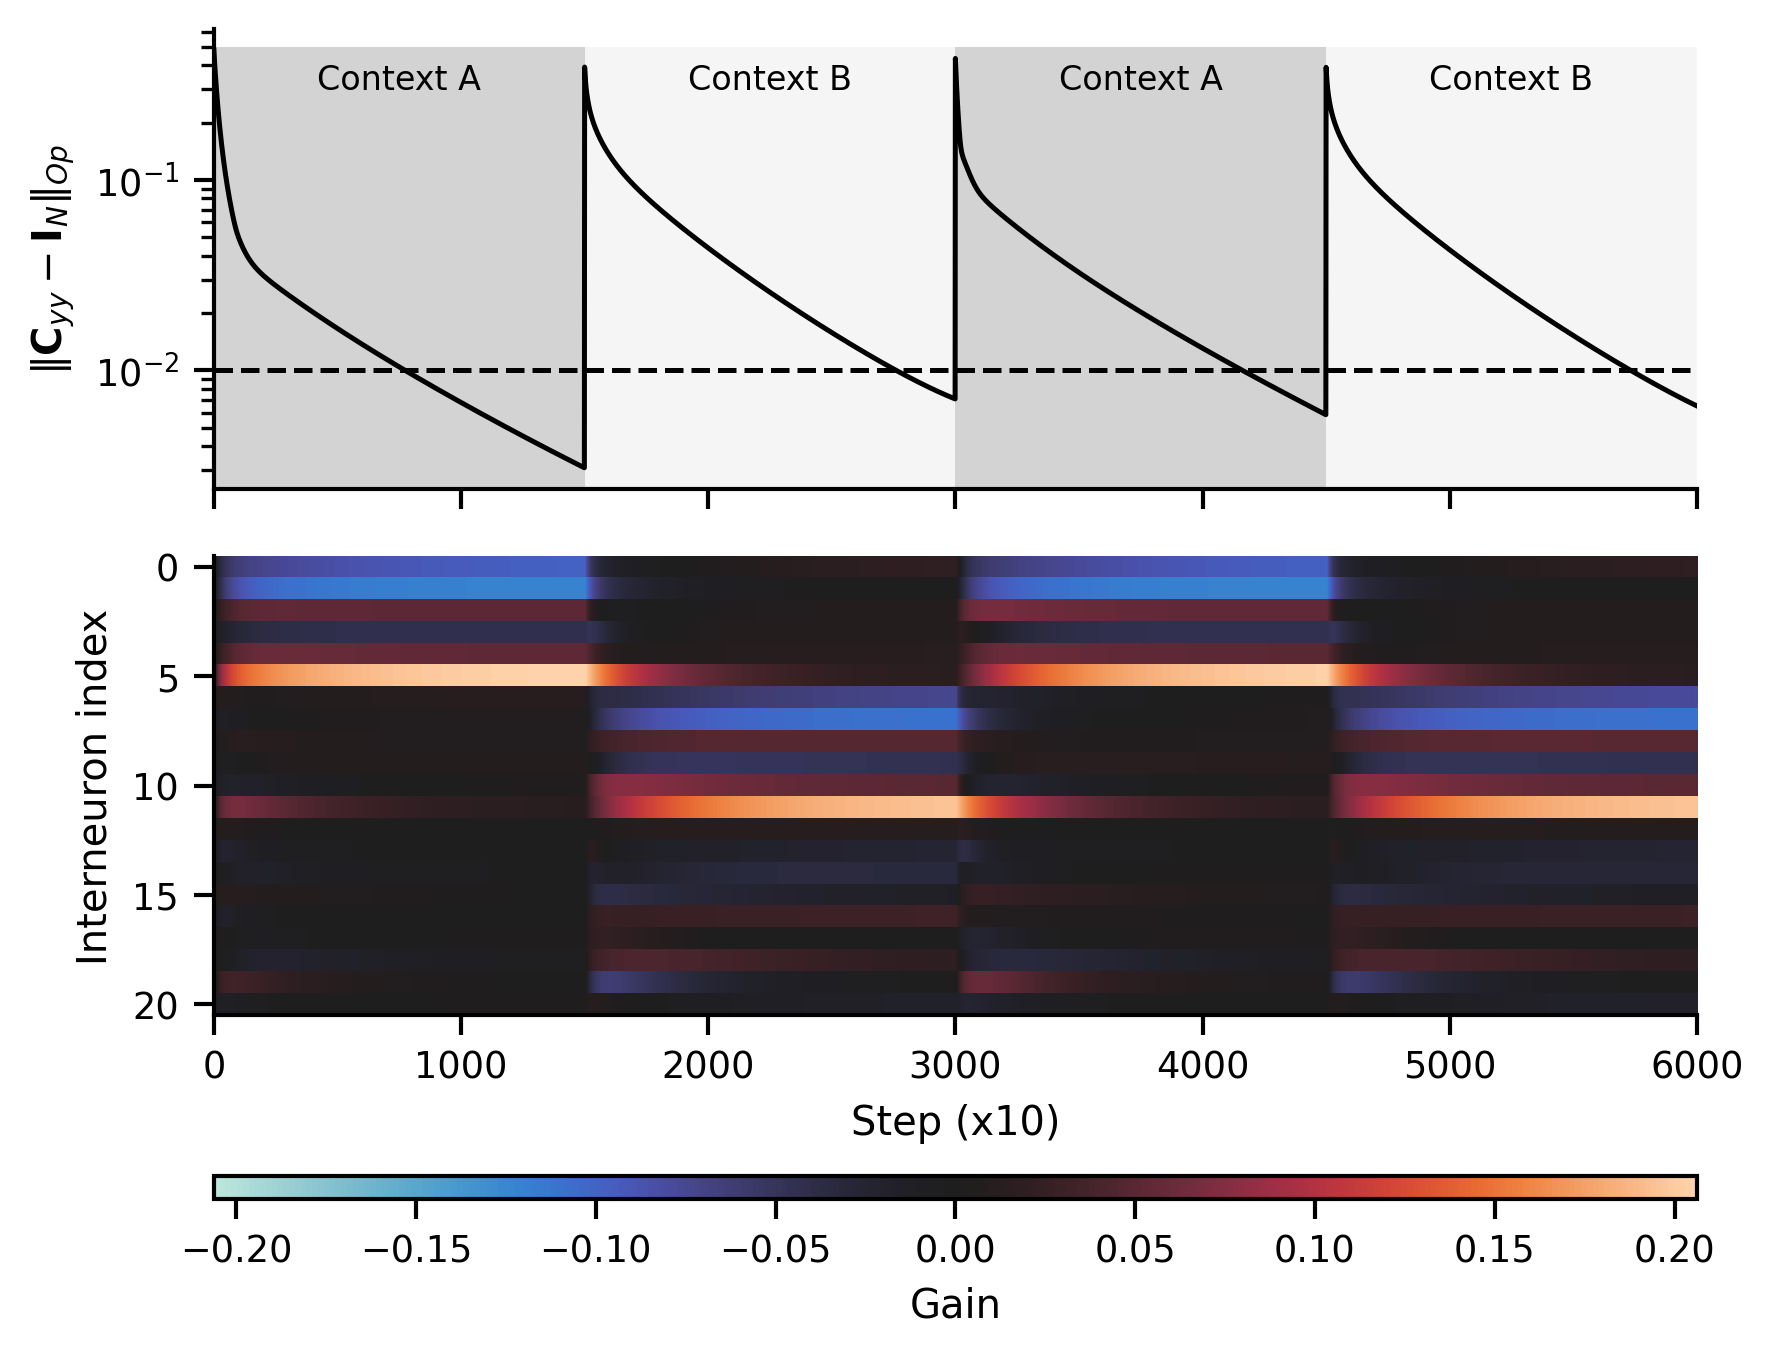

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

g_all_plot = g_all[0:]
cmap = sns.color_palette('icefire', as_cmap=True)
vmax = np.max(np.abs(g_all_plot))
vmin = -vmax

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(2, 1, sharex='all', figsize=(6, 4), dpi=300)
    ax[0].plot(errors, color='k')
    ax[0].hlines(1E-2, 0, len(errors), color='k', linestyle='--')
    im = ax[1].imshow(g_all_plot.T, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax, interpolation='none')

    # ax[0].set(yscale='log', ylabel=r'$\frac{1}{N^2}\Vert{\bf C}_{yy} - {\bf I}_N\Vert_2$')
    ax[0].set(yscale='log', ylabel=r'$\Vert{\bf C}_{yy} - {\bf I}_N\Vert_{Op}$')
    ax[1].set(xlabel='Step (x10)', ylabel='Interneuron index')

    sns.despine()
    fig.tight_layout()

    # plot filled rectangle from y = 1E-6 to 1E-2 and from x = to 1000 on ax[0]
    from matplotlib.patches import Rectangle
    recta1 = Rectangle((0, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='lightgrey', zorder=-1)
    recta2 = Rectangle((3000, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='lightgrey', zorder=-1)
    ax[0].add_patch(recta1)
    ax[0].add_patch(recta2)
    # shift rightward by 1500
    rectb1 = Rectangle((1500, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='whitesmoke', zorder=-1)
    rectb2 = Rectangle((4500, 1E-6), 1500, 5E-1, linewidth=1, edgecolor='none', facecolor='whitesmoke', zorder=-1)
    ax[0].add_patch(rectb1)
    ax[0].add_patch(rectb2)

    # place text saying 'Context 1' and 'Context 2' on ax[0]
    ax[0].text(750, 3E-1, 'Context A', fontsize=8, ha='center')
    ax[0].text(1500+750, 3E-1, 'Context B', fontsize=8, ha='center')
    ax[0].text(1500*2 + 750, 3E-1, 'Context A', fontsize=8, ha='center')
    ax[0].text(1500*3 + 750, 3E-1, 'Context B', fontsize=8, ha='center')


    axins = inset_axes(ax[1],
                        width="100%",  
                        height="5%",
                        loc='lower center',
                        borderpad=-5
                    )
    fig.colorbar(im, cax=axins, orientation="horizontal", label="Gain")
